*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module04_03_kernels.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# The nonlinear SVM:  kernels

In this notebook we will introduce the ability of SVM to generate non-linear decision boundaries by using the concept of a kernel.
But first we will do so using the same trick we have previously used of mapping our data using a nonlinear function.

### Nonlinear decision boundaries using polynomial features

Next, we will show how to use polynomial features to handle data that is not linearly separable.

As a toy example, we will use data generated using scikit-learn's [make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function:

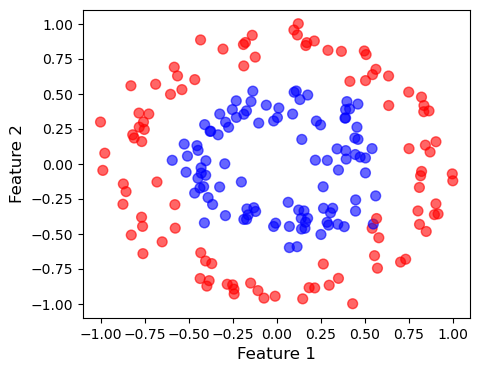

In [29]:
from sklearn.datasets import make_circles
X,y = make_circles(n_samples=200, noise=0.1, random_state=42, factor=0.5)
# n_samples is the number of examples to generate
# noise parameter is the standard deviation of Gaussian noise 
# added to the data.
# factor: scale factor between inner and outer circle

# next:  scale data to be between -1 and 1:

X[:,0] = 2 * (X[:,0] - min(X[:,0])) / (max(X[:,0]) - min(X[:,0])) - 1
X[:,1] = 2 * (X[:,1] - min(X[:,1])) / (max(X[:,1]) - min(X[:,1])) - 1

fig=plt.figure(figsize=(5,4))
ax  = fig.add_subplot(111)
colors = ['r' if y[i] == 0 else 'b' for i in range(len(y))]
ax.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6) 
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12);

Clearly, this data is not linearly separable.  To obtain a classifier that is able to classify this data we will use the same approach we used in basis function regression:  apply a nonlinear function to our data.  Rather than classify the original data, we will first apply a function $\Phi(\mathbf{x})$ to our feature vectors:

$$
\Phi(\mathbf{x}) = (\phi_1(\mathbf{x}),\ldots,\phi_D(\mathbf{x})).
$$

The collection of functions $\phi_1(\mathbf{x}), \ldots, \phi_D(\mathbf{x})$ are the basis functions.  As we have done previously, we will use monomials up to a given degree as our basis functions.
For example, for two dimensional data $\mathbf{x} = (x_1, x_2)$ and monomials with degree up to 2 the resulting set of features is

$$
(1, x_1, x_2, x_1^2, x_2^2, x_1 x_2).
$$

The dot product in the space of our polynomial features takes on the form:

$$
\mathbf{w}^{\top} \Phi(\mathbf{x}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + w_5 x_1 x_2
$$

For example:

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
# include bias determines if to include the case where all feature 
# powers are zero; this serves as a bias term 
poly.fit_transform(np.array([[1, 2], [3, 4]]))

array([[ 1.,  2.,  1.,  2.,  4.],
       [ 3.,  4.,  9., 12., 16.]])

Here's code for plotting the decision surface of the SVM:

In [32]:
plot_str = ['or', '+b']
xmin = -1
xmax = 1
ymin = -1
ymax = 1

def decision_surface(classifier, X, y, ax=None) :
    is_svm = True
    markersize=5
    fontsize = 'medium'
    contour_fontsize = 10
    # setting up the grid
    delta = 0.01
    xx = np.arange(xmin, xmax, delta)
    yy = np.arange(ymin, ymax, delta)

    YY, XX = np.meshgrid(yy, xx)
    xy = np.stack([XX.ravel(), YY.ravel()], axis=-1)
    # alternatively:
    #xy = np.column_stack([XX.ravel(), YY.ravel()])
    #print(xy.shape)

    Z = classifier.decision_function(xy).reshape(XX.shape)

    if ax is None :
        fig = plt.figure(figsize=(4.5,4.5))
        ax = fig.add_subplot()
    im = ax.imshow(np.transpose(Z), 
                   interpolation='bilinear', origin='lower',
                   cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

    if (is_svm) :
        C = ax.contour(np.transpose(Z),
                        [-1,0,1],
                        origin='lower',
                        linewidths=(1,3,1),
                        colors = 'black',
                        extent=(xmin,xmax,ymin,ymax))
    else :
        C = ax.contour(np.transpose(Z),
                        [0],
                        origin='lower',
                        linewidths=(3),
                        colors = 'black',
                        extent=(xmin,xmax,ymin,ymax))

    ax.clabel(C, inline=1, fmt='%1.1f',
              fontsize=contour_fontsize)
    # plot the data
    for i in range(len(X)) :
        ax.plot(X[i][0], X[i][1], plot_str[y[i]], markersize=5, alpha=0.5)
    xticklabels = plt.getp(ax, 'xticklabels')
    yticklabels = plt.getp(ax, 'yticklabels')
    plt.setp(xticklabels, fontsize=fontsize)
    plt.setp(yticklabels, fontsize=fontsize)


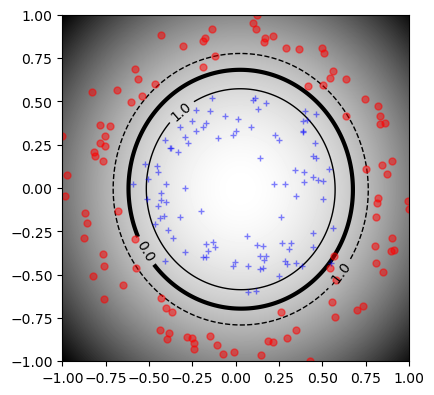

In [33]:
#import warnings
#warnings.filterwarnings('ignore') 
from sklearn.pipeline import make_pipeline
from sklearn import svm

svm2 = make_pipeline(PolynomialFeatures(degree=2,include_bias=False), 
                     svm.SVC(kernel="linear", C=10))

svm2.fit(X,y)
decision_surface(svm2, X, y)

Let's try to understand this a little better by looking at the data in the transformed space:

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_trans = poly.fit_transform(X)
X_trans.shape

(200, 5)

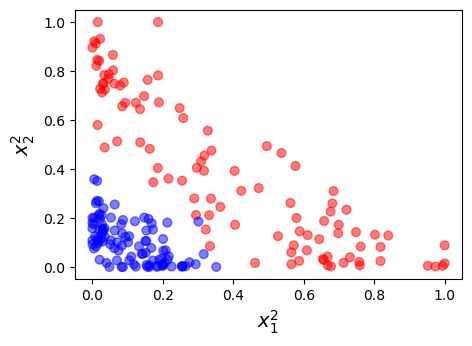

In [37]:
fig = plt.figure(figsize=(5,3.5))
ax  = fig.add_subplot()
colors = ['r' if y[i] == 0 else 'b' for i in range(len(y))]
ax.scatter(X_trans[:, 2], X_trans[:, 4], c=colors, s=40, alpha=0.5) 
ax.set_xlabel(r'$x_1^2$', fontsize=14)
ax.set_ylabel(r'$x_2^2$', fontsize=14);

While the original data was clearly not linearly separable, in the transformed space it is very close to being so!
What we have done, is transform the data in such a way that a linear classifier is all we need.

### Digression:  the soft margin constant and regularization

Now, if we increase the value of $C$, the margin shrinks as we would expect, but the overall shape of the decision boundary is unchanged:

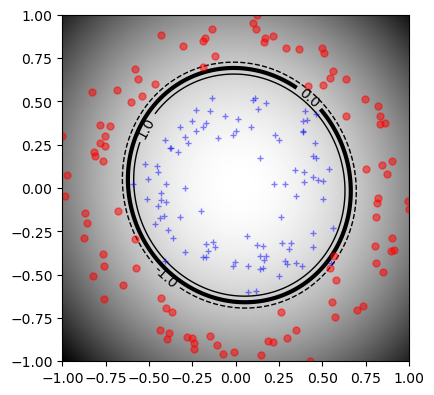

In [38]:
svm2 = make_pipeline(PolynomialFeatures(degree=2,include_bias=False), 
                     svm.SVC(kernel="linear", C=1000))

svm2.fit(X,y)
decision_surface(svm2, X, y)

Now let's increase the power of the monomials used to generate our features.  For a relatively low value of $C$ the shape of the boundary is still more or less a circle:

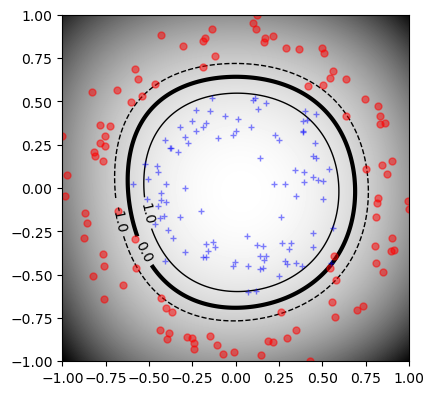

In [39]:
svm5 = make_pipeline(PolynomialFeatures(5), 
                     svm.SVC(kernel="linear", C=10))

svm5.fit(X,y)
decision_surface(svm5, X, y)

However, when we increase the value of $C$, i.e. penalize misclassifications and margin violations, the classifier does its best to fit the data, even if that's not a good idea!

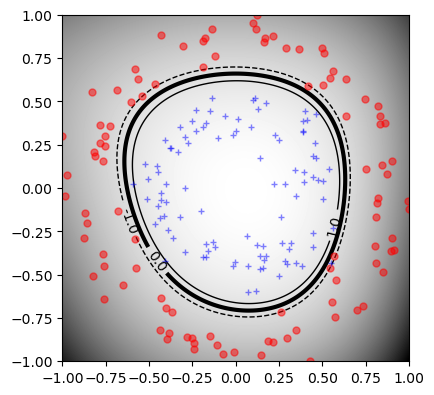

In [40]:
svm5 = make_pipeline(PolynomialFeatures(5), 
                     svm.SVC(kernel="linear", C=1000))

svm5.fit(X,y)
decision_surface(svm5, X, y)

This highlights the role of the soft-margin constant $C$ in controling the extent of regularization.

Recall that the soft-margin SVM is defined by the following optimization problem:

$$
\begin{aligned}
\underset{\mathbf{w}, b}{\mathrm{minimize~}}
 & \frac{1}{2} ||\mathbf{w}||^2  + C \sum_{i=1}^N \xi_i  \\
\mathrm{subject~to:}~~  & y_i \left( \mathbf{w}^{\top} \mathbf{x}_i + b \right) \geq 1 - \xi_i ~~ i = 1,\ldots,N \,,\\
& \xi_i \geq 0 ~~ i = 1,\ldots,N \,.
\end{aligned}
$$

The first term, controls the margin and serves as a regularizer, while the second term controls how hard the classifier tries to classify every data point correctly.

### Mapping your data is not feasible for high dimensional data

The approach of mapping data to a higher dimensional space using a nonlinear function can be highly effective, but suffers from a big drawback:  it becomes less and less feasible as the dimensionality of the input data increases.  SVMs and other kernel-based methods address this issue by *implicitly* mapping the data to a high dimensional space using *kernels*.  

### Can we map our data without explicitly doing so?

The answer to this question is yes.  To get an idea of how that might work, consider the function

$$
\Phi(\mathbf{x}) = (x_1^2, \sqrt{2}x_1x_2, x_2^2)^{\top}
$$

If we map the data using this function then the decision function of our linear classifier is non-linear in terms of our original features:

$$
\mathbf{w}^{\top} \Phi(\mathbf{x}) = w_1x_1^2 + \sqrt{2} w_2 x_1 x_2 + w_3 x_2^2
$$

So far we have not gained anything.  However, suppose the weight vector can be expressed as:

$$
\mathbf{w} = \sum_{i=1}^N \alpha_i \mathbf{x}_i
$$

In the space of the transformed data:

$$
\mathbf{w} = \sum_{i=1}^N \alpha_i \Phi(\mathbf{x}_i)
$$



The discriminant function is then:

$$
\mathbf{w}^\top \Phi(\mathbf{x}) + b = \sum_{i=1}^N \alpha_i \Phi(\mathbf{x}_i)^\top \Phi(\mathbf{x}) + b
$$

What we see is that it depends on our data only through dot products, and it turns out that for an appropriately chosen function $\Phi$, we can compute the dot product without explicitly mapping the data into a high dimensional feature space.  For example, let's consider our mapping from above 

$$
\Phi(\mathbf{x}) = (x_1^2, \sqrt{2}x_1x_2, x_2^2)^{\top}
$$

And compute 

$$
\begin{aligned}
\Phi(\mathbf{x})^\top \Phi(\mathbf{z}) & = (x_1^2, \sqrt{2}x_1x_2, x_2^2)^{\top} (z_1^2, \sqrt{2}z_1 z_2, z_2^2) \\
     & = x_1^2 z_1^2 + 2 x_1 x_2 z_1 z_2 + x_2^2 z_2^2 \\
     & = (\mathbf{x}^\top \mathbf{z})^2.
\end{aligned}
$$

This means, that if we can express our machine learning algorithm using dot products, we don't need to compute the mapping explicitly:
Squaring the dot product in the original space has the same effect as computing the dot product in the transformed space.


### Kernels

**Definition:**  A function $k(\mathbf{x}, \mathbf{z})$ that can be expressed as a dot product in some feature space is called a kernel.

In other words, $k(\mathbf{x}, \mathbf{z})$ is a kernel if there exists a function $\Phi: \mathcal{x} \mapsto \mathcal{F}$
such that 

$$
k(\mathbf{x}, \mathbf{z}) = \Phi(\mathbf{x})^\top \Phi(\mathbf{z})
$$

Why is this interesting?

If the algorithm can be expressed in terms of dot products, we can work in the feature space without performing the mapping explicitly!
And it turns out the large margin optimization problem used to train SVMs can be expressed in terms of dot products.  

### Standard kernel functions

The linear kernel
$$
k(\mathbf{x}, \mathbf{z}) = \mathbf{x}^\top \mathbf{z}
$$

The homogeneous polynomial kernel of degree $D$

$$
k(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^\top \mathbf{z})^D
$$

The polynomial kernel of degree $D$

$$
k(\mathbf{x}, \mathbf{z}) = (1 + \mathbf{x}^\top \mathbf{z})^D
$$

The Gaussian kernel

$$
k(\mathbf{x}, \mathbf{z}) = \exp(-\gamma ||\mathbf{x} - \mathbf{z}||^2)
$$

Each of these kernels implicitly represents the data in a high dimensional feature space.  Do you have some ideas on what those might be?  For the Gaussian kernel, it happens to be infinite dimensional.  This is discussed in detail e.g. in:

* Shawe-Taylor, John, and Nello Cristianini. Kernel methods for pattern analysis. Cambridge university press, 2004.

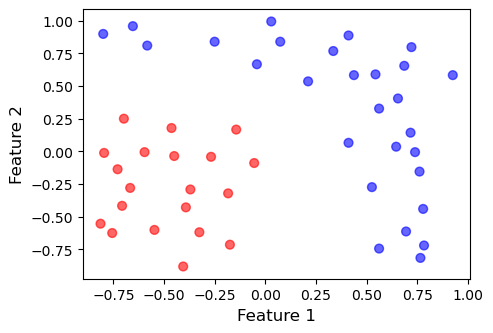

In [44]:
X = np.array([[-0.7289242898264241, -0.13617135002499547],
 [-0.6668275156328757, -0.27902849288213827],
 [-0.7067468704715854, -0.41593325478690024],
 [-0.5470694511167467, -0.6004570643107098],
 [-0.39182751563287566, -0.4278380166916621],
 [-0.3696500962780369, -0.29093325478690013],
 [-0.2676339672457788, -0.04093325478690035],
 [-0.44948880595545626, -0.0349808738345192],
 [-0.4627952575683595, 0.179304840451195],
 [-0.18335977369739176, -0.320695159548805],
 [-0.17448880595545635, -0.7135523024059478],
 [-0.40513396724577877, -0.8802189690726145],
 [-0.3252952575683594, -0.6183142071678526],
 [-0.05473074143932721, -0.0885523024059478],
 [-0.14344041885868197, 0.16740007854643313],
 [-0.5825533220844885, 0.8102572214035757],
 [-0.24989203176190777, 0.8400191261654808],
 [0.07389829081873733, 0.8400191261654808],
 [0.33559183920583413, 0.7685905547369092],
 [0.544059581141318, 0.5900191261654808],
 [0.6549466779155115, 0.40549531664167127],
 [0.7170434521090598, 0.14359055473690918],
 [0.7392208714638988, -0.005218969072614543],
 [0.7613982908187373, -0.15402849288213827],
 [0.7791402263026082, -0.4397427785964241],
 [0.7835757101735763, -0.7195046833583288],
 [0.765833774689705, -0.8147427785964241],
 [0.4109950650122858, 0.06620960235595685],
 [0.4376079682380922, 0.5840667452130996],
 [0.7214789359800275, 0.7983524594988138],
 [0.9255111940445437, 0.5840667452130996],
 [0.4109950650122858, 0.8876381737845283],
 [0.029543452109059842, 0.9947810309273855],
 [-0.6535210640199725, 0.9590667452130999],
 [-0.0414242898264241, 0.6674000785464329],
 [0.2113982908187373, 0.5364476975940522],
 [0.6859950650122859, 0.655495316641671],
 [0.526317645657447, -0.27307611192975734],
 [0.6948660327542213, -0.6123618262154716],
 [0.6460757101735761, 0.0364476975940522],
 [0.5618015166251888, 0.3281143642607187],
 [-0.5958597736973917, -0.005218969072614543],
 [-0.7954565478909402, -0.011171350024995474],
 [-0.7555371930522305, -0.6242665881202336],
 [-0.8131984833748112, -0.5528380166916621],
 [-0.6978759027296498, 0.2507334118797664],
 [-0.7998920317619079, 0.8995429356892901],
 [0.5618015166251888, -0.7433142071678526]])
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1])

fig = plt.figure(figsize=(5,3.5))
ax  = fig.add_subplot(111)
colors = ['r' if y[i] == 0 else 'b' for i in range(len(y))]
ax.scatter(X[:, 0], X[:, 1], c=colors, s=40, alpha=0.6) 
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12);

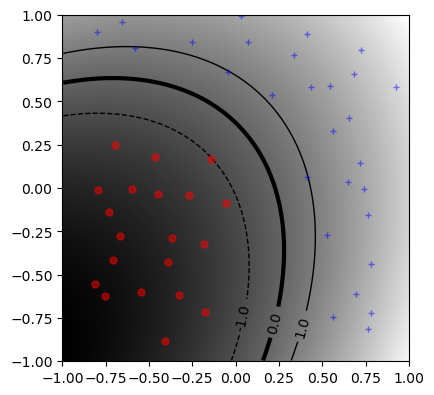

In [45]:
svm_poly = svm.SVC(kernel="poly", degree=2, coef0=1, C=10)

svm_poly.fit(X,y)
decision_surface(svm_poly, X, y)

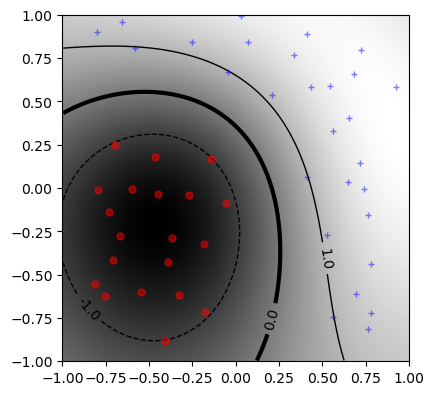

In [46]:
svm_poly = svm.SVC(kernel="rbf", gamma=1, C=10)

svm_poly.fit(X,y)
decision_surface(svm_poly, X, y)

#### Exercise

Explore the toy dataset above by varying the value of the parameter $\gamma$ of the Gaussian kernel.  

### Nonlinear SVM on real data

A question frequently posed by practitioners is *which kernel
should I use for my data?* There are several answers to this question. The first is that it is, like most practical questions in machine
learning, data dependent, so several kernels should be tried. 
That being said, we typically follow the following procedure: try a linear kernel first, and then see if you can improve on its performance
using a nonlinear kernel. The linear kernel provides a useful baseline,
and in many applications provides the best results.
The flexibility of the Gaussian and polynomial kernels can lead to
overfitting in high-dimensional datasets. Furthermore,
an SVM with a linear kernel is easier to tune since the only parameter
that affects performance is the soft-margin constant. Once a result
using a linear kernel is available, it can serve as a baseline that you can try to improve upon using a nonlinear kernel. Between the Gaussian
and polynomial kernels, our experience shows that the Gaussian
kernel usually outperforms the polynomial kernel in both accuracy
and convergence time if the data are normalized correctly and a
good value of the width parameter and soft-margin constant are chosen.

Let's explore the breast cancer dataset with various kernels:

In [47]:
from sklearn.datasets import load_breast_cancer
X,y = data = load_breast_cancer(return_X_y = True)
X.shape, y.shape

((569, 30), (569,))

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5)

As a first take, let's try the nonlinear SVM with Gaussian kernel with values that used to be the defaults in scikit-learn:

In [49]:
classifier = svm.SVC(kernel="rbf", gamma=1, C=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print('accuracy: ', np.mean(y_test == y_pred))

accuracy:  0.6432748538011696


This was a complete failure! The Gaussian kernel requires careful tuning of the width hyper-parameter $\gamma$.  Let's see how performance varies as vary its value:

gamma: 1e-06	 accuracy: 0.959
gamma: 1e-05	 accuracy: 0.971
gamma: 0.0001	 accuracy: 0.971
gamma: 0.001	 accuracy: 0.953
gamma: 0.01	 accuracy: 0.649
gamma: 0.1	 accuracy: 0.643
gamma: 1.0	 accuracy: 0.643
gamma: 10.0	 accuracy: 0.643
gamma: 100.0	 accuracy: 0.643


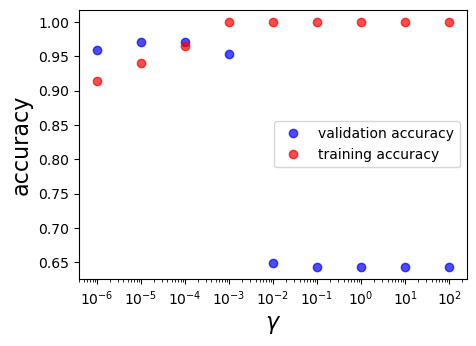

In [51]:
gammas = np.logspace(-6, 2, num=9, endpoint=True, base=10.0)

accuracies = []
training_accuracies = []
for gamma in gammas :
    classifier = svm.SVC(kernel="rbf", gamma=gamma, C=10)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = np.mean(y_test == y_pred)
    y_pred_train = classifier.predict(X_train)
    training_accuracy = np.mean(y_train==y_pred_train)
    training_accuracies.append(training_accuracy)
    print(f"gamma: {gamma}\t accuracy: {accuracy:0.3f}")
    accuracies.append(np.mean(y_test == y_pred))

plt.figure(figsize=(5,3.5))
plt.semilogx(gammas, accuracies, 'ob', alpha=0.7, 
             label="validation accuracy");
plt.semilogx(gammas, training_accuracies, 'or', alpha=0.7, 
             label="training accuracy");
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend();

gamma: 1e-06	 accuracy: 0.643
gamma: 1e-05	 accuracy: 0.848
gamma: 0.0001	 accuracy: 0.971
gamma: 0.001	 accuracy: 0.988
gamma: 0.01	 accuracy: 0.982
gamma: 0.1	 accuracy: 0.942
gamma: 1.0	 accuracy: 0.649
gamma: 10.0	 accuracy: 0.643
gamma: 100.0	 accuracy: 0.643


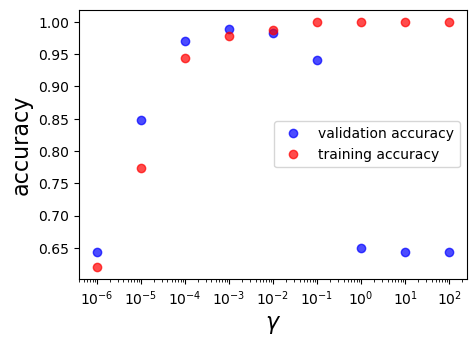

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
    
gammas = np.logspace(-6, 2, num=9, endpoint=True, base=10.0)

accuracies = []
training_accuracies = []
for gamma in gammas :
    classifier = Pipeline([('scaler', StandardScaler()), ('svc', svm.SVC(kernel="rbf", gamma=gamma, C=10))])
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = np.mean(y_test == y_pred)
    y_pred_train = classifier.predict(X_train)
    training_accuracy = np.mean(y_train==y_pred_train)
    training_accuracies.append(training_accuracy)
    print(f"gamma: {gamma}\t accuracy: {accuracy:0.3f}")
    accuracies.append(np.mean(y_test == y_pred))
    
plt.figure(figsize=(5,3.5))
plt.semilogx(gammas, accuracies, 'ob', alpha=0.7, 
             label="validation accuracy");
plt.semilogx(gammas, training_accuracies, 'or', alpha=0.7, 
             label="training accuracy");
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend();

As an aside, let's run the SVM with Gaussian kernel with the default value of $\gamma$:

In [53]:
classifier = svm.SVC(kernel="rbf")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print('accuracy: ', np.mean(y_test == y_pred))

accuracy:  0.9649122807017544


The scikit-learn SVC implementation uses a clever way to set the value of $\gamma$ as described in the [SVC documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html); however, while this is a reasonable choice, it's usually not the optimal value.

As yet another way to preprocess the data, we will convert our feature vectors into unit vectors, and see how that affects the performance of the classifier:

In [54]:
X_normalized = X.copy()
X_normalized = StandardScaler().fit_transform(X_normalized)
for i in range(len(X_normalized)): 
    X_normalized[i] = X_normalized[i] / np.linalg.norm(X_normalized[i])

In [55]:
np.linalg.norm(X_normalized[0])

0.9999999999999999

In [56]:
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.3, random_state=5)

gamma: 1e-06	 accuracy: 0.643
gamma: 1e-05	 accuracy: 0.643
gamma: 0.0001	 accuracy: 0.643
gamma: 0.001	 accuracy: 0.959
gamma: 0.01	 accuracy: 0.982
gamma: 0.1	 accuracy: 0.977
gamma: 1.0	 accuracy: 0.977
gamma: 10.0	 accuracy: 0.883
gamma: 100.0	 accuracy: 0.643


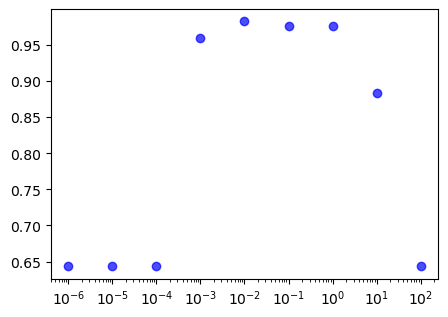

In [58]:
gammas = np.logspace(-6, 2, num=9, endpoint=True, base=10.0)

accuracies = []
for gamma in gammas :
    classifier = svm.SVC(kernel="rbf", gamma=gamma, C=10)
    classifier.fit(X_train_normalized, y_train)
    y_pred = classifier.predict(X_test_normalized)
    accuracy = np.mean(y_test == y_pred)
    print(f"gamma: {gamma}\t accuracy: {accuracy:0.3f}")
    accuracies.append(np.mean(y_test == y_pred))

plt.figure(figsize=(5,3.5))
plt.semilogx(gammas, accuracies, 'ob', alpha=0.7);

### Conclusions

In this notebook we explored how to convert a linear classifier into a non-linear classifier by replacing dot products with kernel functions.  This is a very powerful approach that was very dominant in the machine learning community.  Problem solving using kernels is about designing kernels that are appropriate for representing a given domain.  For approaches relevant for DNA and RNA sequences for example, see:

* Ben-Hur, Asa, Cheng Soon Ong, Sören Sonnenburg, Bernhard Schölkopf, and Gunnar Rätsch. [Support vector machines and kernels for computational biology](http://www.ploscompbiol.org/article/info:doi/10.1371/journal.pcbi.1000173). PLoS computational biology 4, no. 10 (2008): e1000173.

An entirely different approach to achieving non-linearity is to use neural networks.  Neural networks produce non-linear decision boundaries by using multiple layers of perceptron-like units.  Whereas the non-linearity provided by kernels is fixed by the choice of the kernel, neural networks essentially learn a nonlinearity that is appropriate for representing the given classification problem as we will see later in the course.